# **Face Recognition Model Comparison: Analyzing Performance of Multiple Architectures**

In this notebook, explore and compare various deep learning architectures for face recognition. The goal is to train and evaluate five different models to identify the best performing architecture for LFWPeople dataset. Use a combination of well-known models, including **FaceNet (ResNet50), FaceNet (InceptionResnetV1), ArcFace, VGGFace, and Dlib**.

By the end of this notebook, Will have a clear understanding of how each model performs, visualize the training progress, and identify the most accurate model.


In [2]:
# Install required packages
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=af1023492029881ead4da4c22ca71c48ee7214c4deabc45254109489991698d3
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
!pip install facenet-pytorch dlib face_recognition torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 55.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
import bz2
import shutil
import requests
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms, datasets
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import threading
import torch.nn.functional as F
import torchvision.models as models
from torchviz import make_dot
from torchvision.utils import make_grid
from IPython.display import Image
from facenet_pytorch import InceptionResnetV1

import warnings
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Function to download files with progress bar
def download_file(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
    
    with open(filename, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

# Function to extract bz2 files
def extract_bz2(filename):
    print(f"Extracting {filename}...")
    with bz2.BZ2File(filename, 'rb') as source, open(filename[:-4], 'wb') as dest:
        shutil.copyfileobj(source, dest)
    os.remove(filename)  # Remove the compressed file
    print(f"Extracted {filename}")

# Download and extract required Dlib models
def setup_dlib_models():
    models = {
        'dlib_face_recognition_resnet_model_v1.dat': 
            'http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2',
        'shape_predictor_68_face_landmarks.dat': 
            'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    }
    
    for model_name, url in models.items():
        if not os.path.exists(model_name):
            print(f"Downloading {model_name}...")
            compressed_file = f"{model_name}.bz2"
            download_file(url, compressed_file)
            extract_bz2(compressed_file)
        else:
            print(f"{model_name} already exists.")

## **Dataset Preparation**

To train models, first prepare a dataset consisting of face images with labels for each individual. The data is split into training and validation sets, ensuring a balanced distribution for reliable evaluation. Then create data loaders that handle batching and shuffling of the dataset, optimizing the training process.


In [6]:
def prepare_data():
    # Advanced data augmentation
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Download and load the LFW dataset
    lfw_dataset = datasets.LFWPeople(root='./data', download=True, transform=data_transforms)

    # Extract labels from the dataset
    labels = [label for _, label in lfw_dataset]

    # Organize data by person ID
    person_to_indices = {}
    for idx, label in enumerate(labels):
        if label not in person_to_indices:
            person_to_indices[label] = []
        person_to_indices[label].append(idx)

    # Split each person's images into train/val sets
    train_indices = []
    val_indices = []
    for person, indices in person_to_indices.items():
        if len(indices) > 1:
            # If a person has more than one image, split them between training and validation
            train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
            train_indices.extend(train_idx)
            val_indices.extend(val_idx)
        else:
            # If a person has only one image, put it in the training set
            train_indices.extend(indices)

    # Create Subsets for training and validation
    train_dataset = torch.utils.data.Subset(lfw_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(lfw_dataset, val_indices)

    # Create DataLoader objects
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True,
        num_workers=2, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=32, 
        shuffle=False,
        num_workers=2,  
        pin_memory=True
    )
    
    # Show the sample data with improved formatting
    show_sample_data(train_loader, lfw_dataset)

    return train_loader, val_loader, len(lfw_dataset.class_to_idx)

In [7]:
def show_sample_data(loader, dataset, num_images=8, rows=2):

    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Calculate columns based on number of images and rows
    cols = num_images // rows
    
    # Create image grid with increased padding
    img_grid = make_grid(images[:num_images], nrow=cols, normalize=True, padding=20)
    
    # Create figure
    plt.figure(figsize=(15, 8))
    
    # Create the main axis for images
    ax = plt.gca()
    ax.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    ax.axis('off')
    
    # Create reverse mapping of idx to class name
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    
    # Calculate grid dimensions
    grid_width = img_grid.size(2) / cols
    grid_height = img_grid.size(1) / rows
    
    # Style configurations
    label_font_size = 10
    background_color = '#2C3E50'  # Dark blue background for labels
    text_color = 'white'
    label_height = 25
    
    for i, label in enumerate(labels[:num_images]):
        person_name = idx_to_class[label.item()].replace('_', ' ') 
        
        # Calculate positions
        col = i % cols
        row = i // cols
        
        # Calculate center positions for the label
        x_center = col * grid_width + grid_width/2
        y_position = (row + 1) * grid_height - label_height/2
        
        # Add background rectangle for the label
        rect = Rectangle((col * grid_width + 10, y_position - label_height/2),
                        grid_width - 20, label_height,
                        facecolor=background_color,
                        alpha=0.9,
                        edgecolor='none',
                        zorder=2)
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_center, y_position,
                person_name,
                color=text_color,
                fontsize=label_font_size,
                fontweight='bold',
                ha='center',
                va='center',
                zorder=3)
    
    # Add title with proper styling
    plt.title("Sample Training Data with Names",
              pad=20,
              fontsize=16,
              fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    plt.close()

## **Model Architectures and Fine-Tuning Strategy**

Explore five different face recognition models, each with a distinct architecture and fine-tuning approach. Fine-tuning specific layers allows the models to retain useful pre-trained features while adapting to our face recognition task. Below is a summary of each model's architecture and fine-tuning details:

1. **FaceNet (ResNet50)**:
   - **Architecture**: Uses a pre-trained ResNet50 model as the base.
   - **Fine-Tuning Strategy**: Freezes all layers except for the final layer (`layer4`) and fully connected (`fc`) layers, allowing only these layers to learn new patterns specific to our dataset.
   - **Modifications**: The final fully connected layer is replaced with a custom classifier consisting of a 512-dimensional linear layer, batch normalization, ReLU activation, dropout, and an output layer.
   

2. **Improved FaceNet (InceptionResnetV1)**:
   - **Architecture**: Based on the InceptionResnetV1 model pre-trained on the VGGFace2 dataset.
   - **Fine-Tuning Strategy**: All layers are frozen except for the `block8` layer, allowing this high-level feature block to adapt to our specific task.
   - **Modifications**: The last batch normalization layer (`last_bn`) is removed, and a custom classifier with a 256-dimensional linear layer, batch normalization, ReLU, dropout, and output layer is added for face recognition.
   

3. **ArcFace (ResNet50)**:
   - **Architecture**: Also uses ResNet50 as the base, similar to FaceNet.
   - **Fine-Tuning Strategy**: Only the final `layer4` and fully connected (`fc`) layers are fine-tuned, leveraging the pre-trained knowledge of earlier layers.
   - **Modifications**: The fully connected layer is replaced with a 512-dimensional linear layer, batch normalization, ReLU, dropout, and output layer for face recognition tasks.
   

4. **VGGFace (VGG16)**:
   - **Architecture**: Based on the VGG16 architecture, which is widely used in face recognition tasks.
   - **Fine-Tuning Strategy**: All layers are frozen except for the last few convolutional layers (from layer 24 onward) in the `features` module, allowing some adaptation in the higher-level feature extraction.
   - **Modifications**: The last classifier layer in `classifier[6]` is replaced with a custom layer that matches the number of classes in our dataset.
   

5. **Dlib (ResNet34)**:
   - **Architecture**: Uses a lighter ResNet34 model as the base.
   - **Fine-Tuning Strategy**: Freezes all layers except for the final `layer4` and fully connected (`fc`) layers, focusing on the higher-level features.
   - **Modifications**: The final fully connected layer is modified to a 256-dimensional linear layer, batch normalization, ReLU, dropout, and output layer.

Each model is optimized for our face recognition task through selective fine-tuning, allowing specific layers to learn new patterns while leveraging the base model's pre-trained features.


In [8]:
class FaceNetModel(nn.Module):
    def __init__(self, num_classes):
        super(FaceNetModel, self).__init__()
        # Load pretrained ResNet50
        self.base = models.resnet50(pretrained=True)
        
        # Freeze early layers
        for name, param in self.base.named_parameters():
            if "layer4" not in name and "fc" not in name:  # Only fine-tune layer4 and fc
                param.requires_grad = False
                
        # Modify final layers for face recognition
        in_features = self.base.fc.in_features
        self.base.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base(x)
    
    
class ImprovedFaceNet(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedFaceNet, self).__init__()
        self.base = InceptionResnetV1(pretrained='vggface2')
        for param in self.base.parameters():
            param.requires_grad = False
        for param in self.base.block8.parameters():
            param.requires_grad = True
        
        # Remove the last batch normalization layer
        self.base.last_bn = nn.Identity()
        
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base(x)
        return self.fc(x)
    
    
class ArcFaceModel(nn.Module):
    def __init__(self, num_classes):
        super(ArcFaceModel, self).__init__()
        # Load pretrained ResNet50
        self.base = models.resnet50(pretrained=True)
        
        # Freeze early layers
        for name, param in self.base.named_parameters():
            if "layer4" not in name and "fc" not in name:  # Only fine-tune layer4 and fc
                param.requires_grad = False
        
        # Replace FC layer
        in_features = self.base.fc.in_features
        self.base.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base(x)


class VGGFaceModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGFaceModel, self).__init__()
        # Load pretrained VGG16
        self.base = models.vgg16(pretrained=True)
        
        # Freeze all layers initially
        for param in self.base.parameters():
            param.requires_grad = False
            
        # Enable fine-tuning for later layers (matching code1)
        for param in self.base.features[24:].parameters():
            param.requires_grad = True
            
        # Replace the final classifier layer (matching code1)
        self.base.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.base(x)
    
    
class DlibFaceModel(nn.Module):
    def __init__(self, num_classes):
        super(DlibFaceModel, self).__init__()
        # Load pretrained ResNet34
        self.base = models.resnet34(pretrained=True)
        
        # Freeze early layers
        for name, param in self.base.named_parameters():
            if "layer4" not in name and "fc" not in name:  # Only fine-tune layer4 and fc
                param.requires_grad = False
        
        # Modify final layers
        in_features = self.base.fc.in_features
        self.base.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base(x)


## **Training the Models**

Each model undergoes a 50-epoch training process, where evaluate its performance on both the training and validation datasets. The models are trained using a cross-entropy loss function, with optimizer parameters dynamically adjusted via a scheduler to ensure stable convergence. For each epoch, the validation accuracy is recorded to help track progress.


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_name):
    scaler = GradScaler()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Use mixed precision training
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history, best_acc

In [10]:
# Visualization function for multiple models
def plot_training_progress(results):
    num_models = len(results)
    plt.figure(figsize=(15, num_models * 5))
    
    for i, (model_name, result) in enumerate(results.items(), 1):
        train_losses = result['history']['train_loss']
        val_losses = result['history']['val_loss']
        train_accs = result['history']['train_acc']
        val_accs = result['history']['val_acc']
        
        # Loss Plot
        plt.subplot(num_models, 2, 2 * i - 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'{model_name} - Loss')

        # Accuracy Plot
        plt.subplot(num_models, 2, 2 * i)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'{model_name} - Accuracy')
    
    plt.tight_layout()
    plt.show()

## **Model Architecture Visualization**

Visualizing the architecture of each model gives us insights into its complexity and feature extraction capabilities. Display the architecture for each model to better understand the layers and parameters that define its performance.


In [11]:
def visualize_model_architecture(model, input_size=(3, 224, 224), batch_size=4):
    model.eval()  # Set the model to evaluation mode
    x = torch.randn(batch_size, *input_size).to(device)
    try:
        y = model(x)
        dot = make_dot(y, params=dict(model.named_parameters()))
        dot.render("model_architecture", format="png")
        display(Image("model_architecture.png"))
    except Exception as e:
        print(f"Error visualizing model architecture: {str(e)}")
        print("Skipping model architecture visualization.")


## **Model Selection and Configuration**

A set of diverse face recognition architectures for comparison, each with a unique approach to feature extraction and classification:

1. **FaceNet with ResNet50 backbone**: Uses a deep ResNet50 architecture for feature extraction.
2. **FaceNet with InceptionResnetV1 backbone**: Combines Inception and ResNet architectures, commonly used for face recognition.
3. **ArcFace**: Incorporates an additive angular margin loss to improve face recognition accuracy by enhancing feature discrimination.
4. **VGGFace**: Built on the VGG architecture, it's trained specifically for face recognition tasks.
5. **Dlib**: A robust face recognition model known for its speed and simplicity, often used in real-time applications.

Each model is configured with a cross-entropy loss function and AdamW optimizer, set to a learning rate of 0.001 and weight decay of 0.01. Also use a learning rate scheduler to adjust the learning rate dynamically based on validation loss.

## **Model Comparison Results**

After training all models, summarize their best validation accuracy scores. This comparison allows us to identify the most effective architecture based on validation performance, providing insights into which model is best suited for face recognition on our dataset.

## **Training Progress Visualization**

To better understand the training dynamics of each model, plot their training and validation accuracy across epochs. This visualization provides a comparative view of each model's learning curve, revealing trends in performance improvement and generalization capabilities.



Setting up Dlib models...


21.4MiB [00:02, 7.66MiB/s]


Extracting dlib_face_recognition_resnet_model_v1.dat.bz2...
Extracted dlib_face_recognition_resnet_model_v1.dat.bz2


64.0MiB [00:06, 10.6MiB/s]


Extracting shape_predictor_68_face_landmarks.dat.bz2...
Extracted shape_predictor_68_face_landmarks.dat.bz2
Preparing datasets...


100%|██████████| 243346528/243346528 [03:48<00:00, 1065445.98it/s]


Extracting ./data/lfw-py/lfw-funneled.tgz to ./data/lfw-py


100%|██████████| 94770/94770 [00:00<00:00, 356895.54it/s]


100%|██████████| 94727/94727 [00:00<00:00, 347733.93it/s]


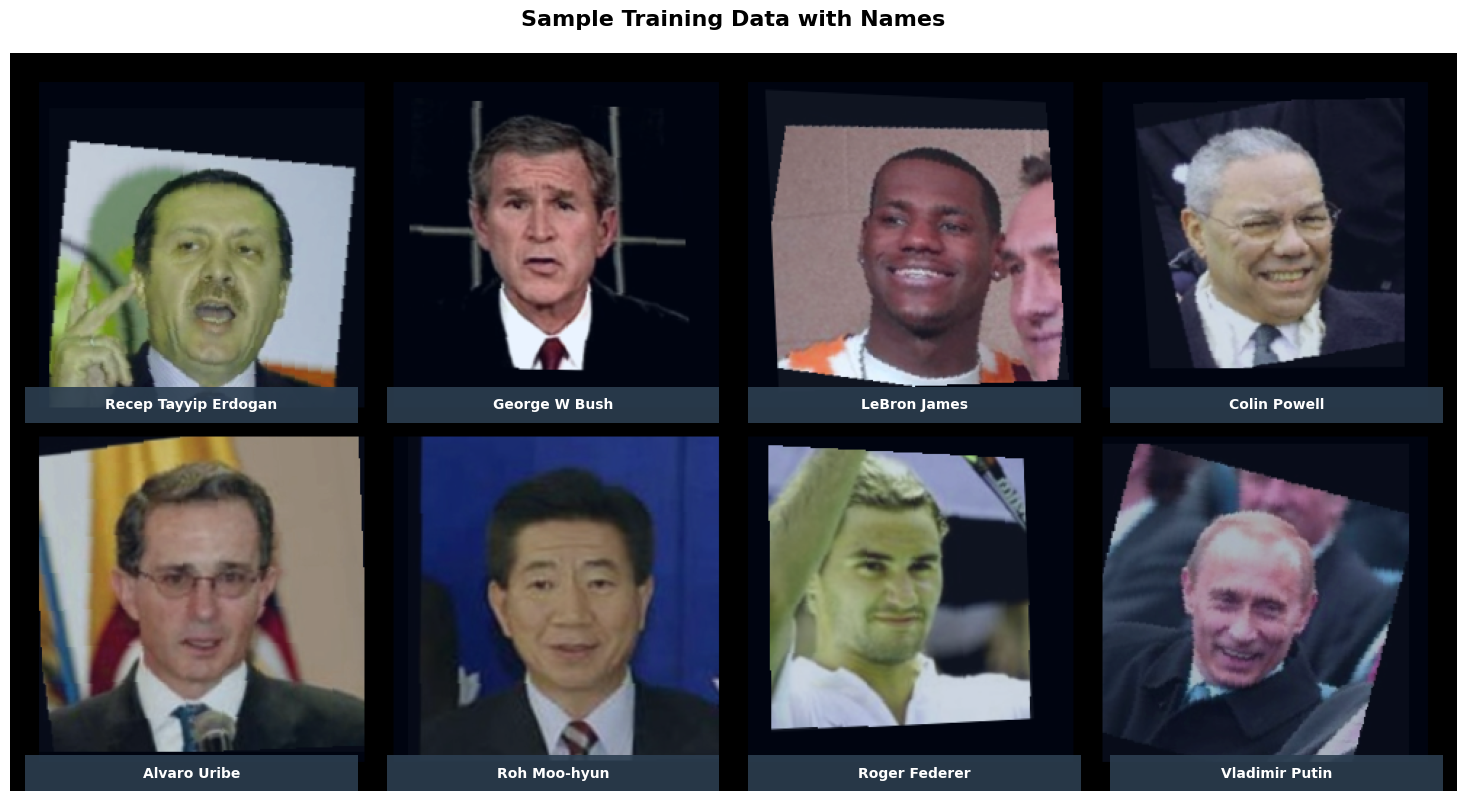

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


  0%|          | 0.00/107M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 179MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]



Preparing FaceNet_ResNet50
Visualizing FaceNet_ResNet50 architecture


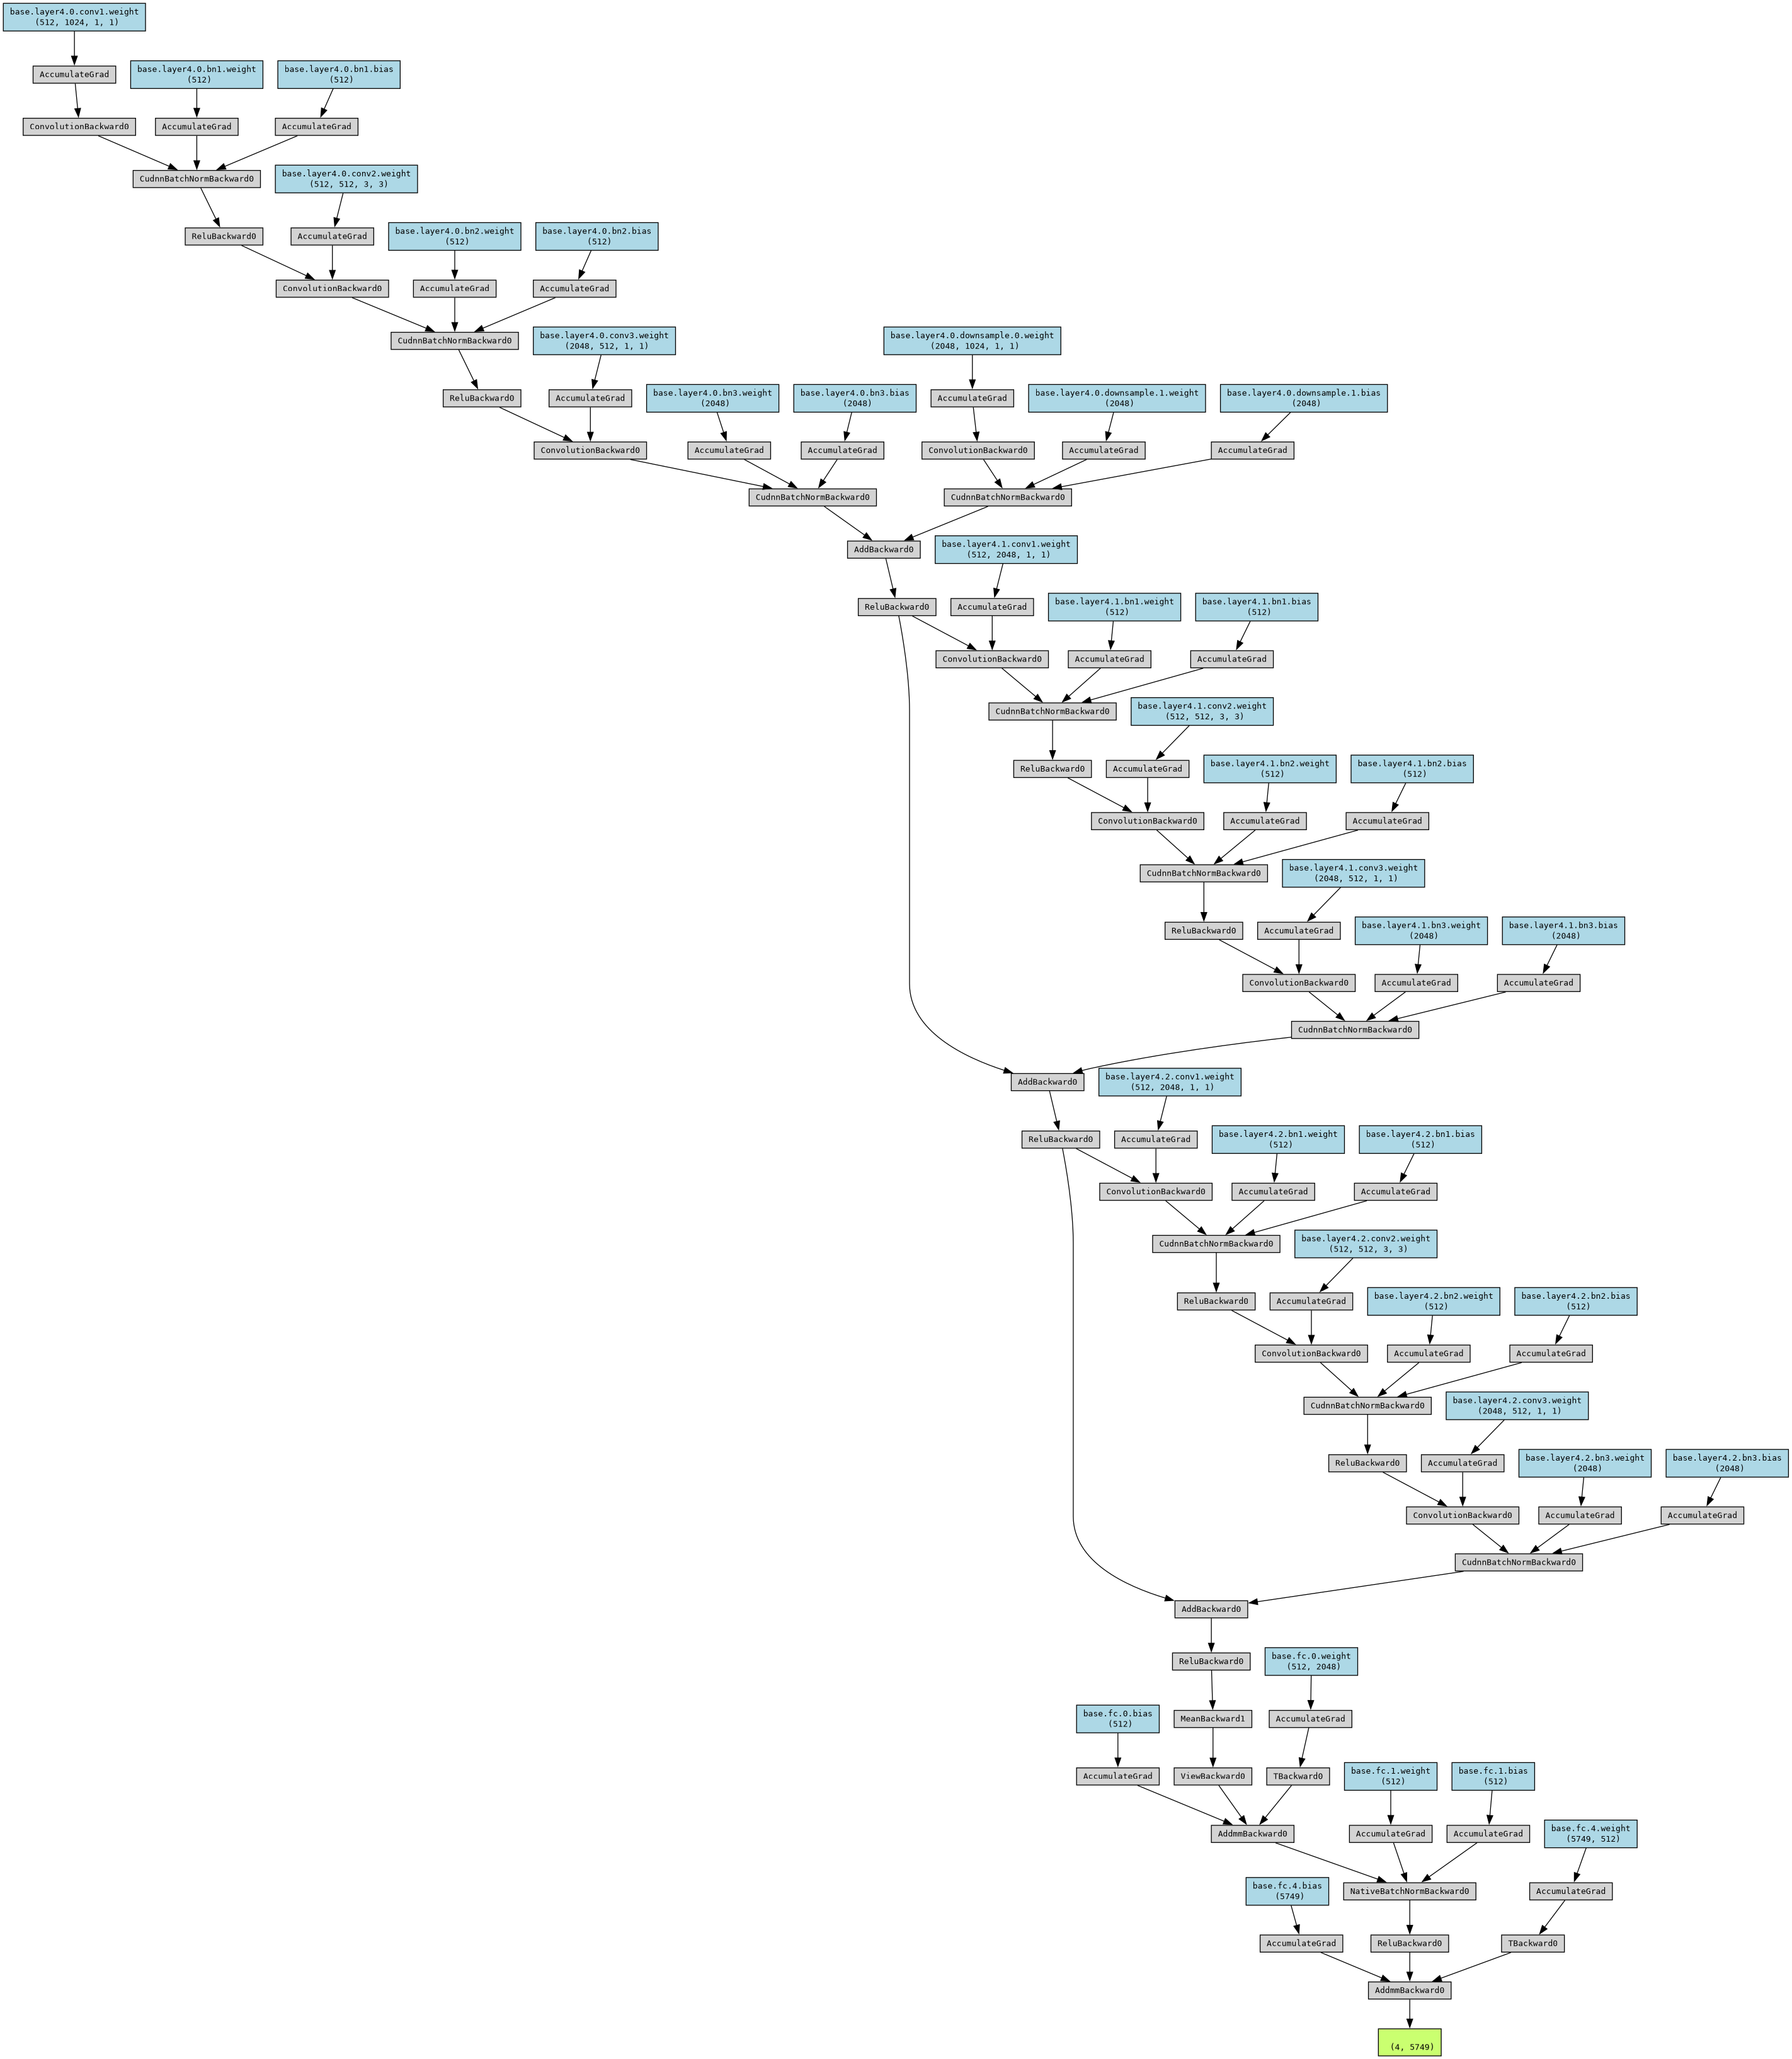


Training FaceNet_ResNet50
Epoch [1/50]
Train Loss: 8.2590, Train Acc: 4.99%
Val Loss: 7.5169, Val Acc: 5.42%
Epoch [2/50]
Train Loss: 7.6269, Train Acc: 6.25%
Val Loss: 7.1541, Val Acc: 6.99%
Epoch [3/50]
Train Loss: 7.3138, Train Acc: 7.34%
Val Loss: 6.8934, Val Acc: 8.42%
Epoch [4/50]
Train Loss: 7.1806, Train Acc: 7.92%
Val Loss: 6.7914, Val Acc: 9.15%
Epoch [5/50]
Train Loss: 6.9345, Train Acc: 8.77%
Val Loss: 6.6674, Val Acc: 9.11%
Epoch [6/50]
Train Loss: 6.6494, Train Acc: 9.81%
Val Loss: 6.2939, Val Acc: 11.49%
Epoch [7/50]
Train Loss: 6.3912, Train Acc: 10.93%
Val Loss: 6.1654, Val Acc: 11.76%
Epoch [8/50]
Train Loss: 6.0910, Train Acc: 11.88%
Val Loss: 5.9751, Val Acc: 13.45%
Epoch [9/50]
Train Loss: 5.7458, Train Acc: 13.31%
Val Loss: 5.8335, Val Acc: 14.26%
Epoch [10/50]
Train Loss: 5.4223, Train Acc: 14.50%
Val Loss: 5.8100, Val Acc: 15.64%
Epoch [11/50]
Train Loss: 5.0617, Train Acc: 16.40%
Val Loss: 5.5681, Val Acc: 17.83%
Epoch [12/50]
Train Loss: 4.7178, Train Acc: 17

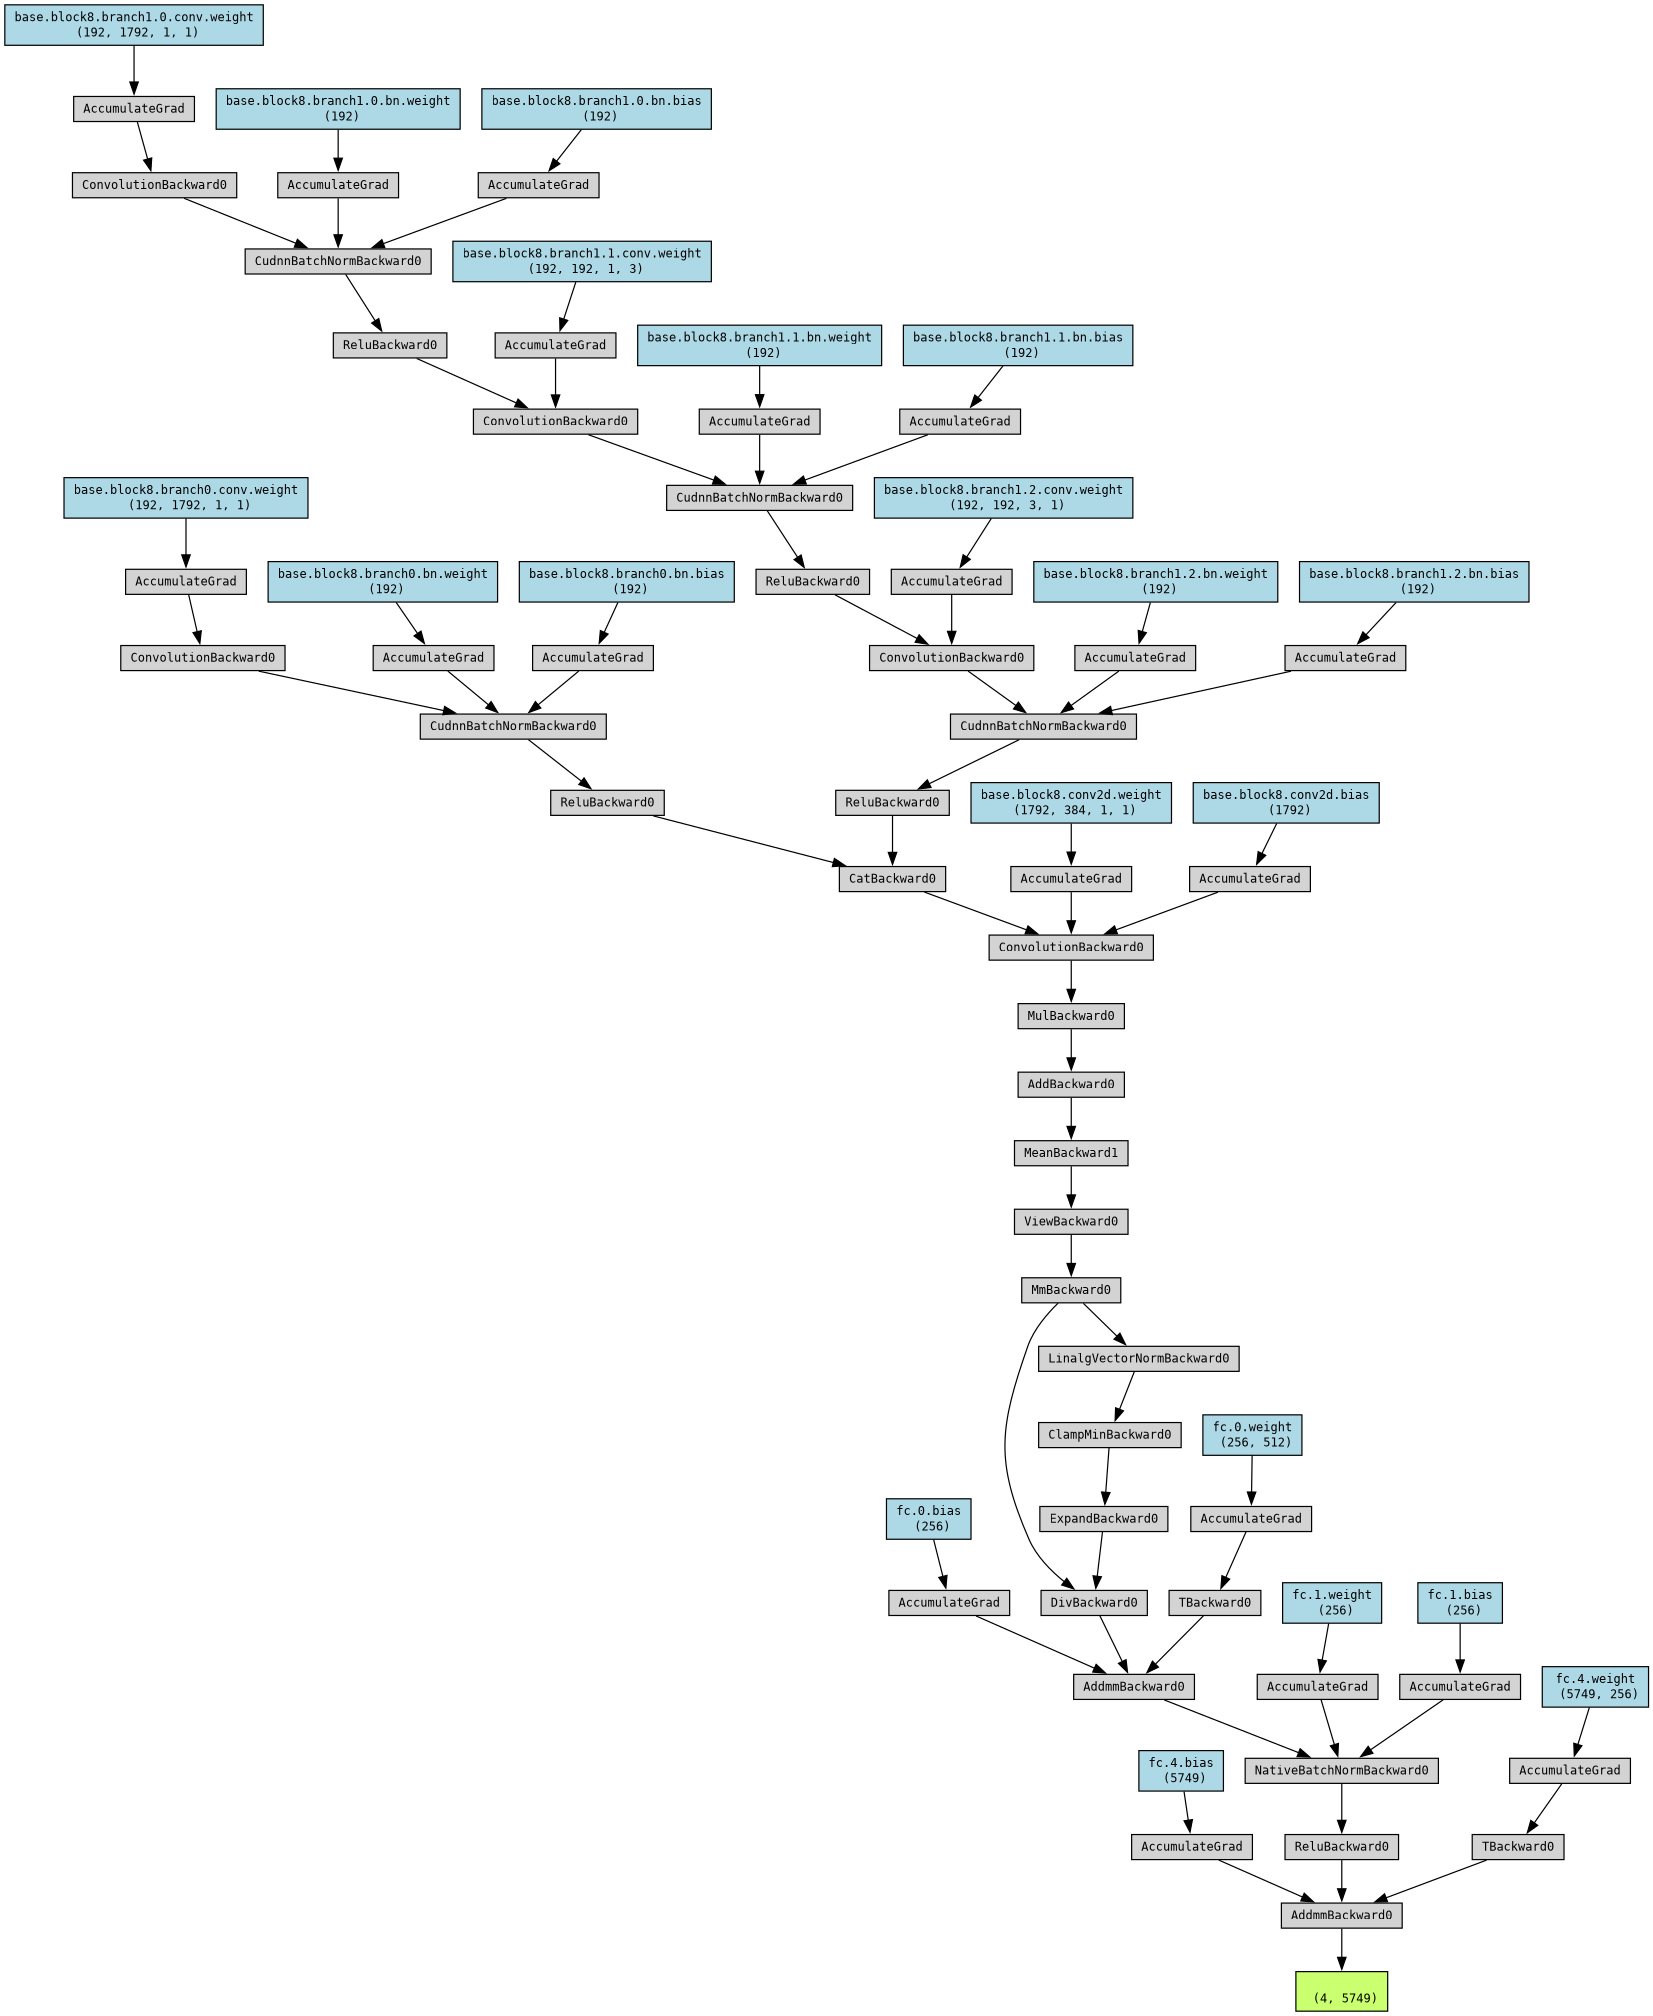


Training FaceNet_InceptionResnetV1
Epoch [1/50]
Train Loss: 7.9454, Train Acc: 8.18%
Val Loss: 7.0707, Val Acc: 10.99%
Epoch [2/50]
Train Loss: 7.2142, Train Acc: 12.20%
Val Loss: 6.3811, Val Acc: 16.87%
Epoch [3/50]
Train Loss: 6.8117, Train Acc: 14.21%
Val Loss: 6.0837, Val Acc: 19.83%
Epoch [4/50]
Train Loss: 6.4737, Train Acc: 16.28%
Val Loss: 5.8048, Val Acc: 19.87%
Epoch [5/50]
Train Loss: 6.1945, Train Acc: 18.00%
Val Loss: 5.4888, Val Acc: 22.71%
Epoch [6/50]
Train Loss: 5.9017, Train Acc: 19.39%
Val Loss: 5.2447, Val Acc: 24.37%
Epoch [7/50]
Train Loss: 5.6089, Train Acc: 20.98%
Val Loss: 4.9915, Val Acc: 26.59%
Epoch [8/50]
Train Loss: 5.3415, Train Acc: 22.61%
Val Loss: 4.8024, Val Acc: 28.06%
Epoch [9/50]
Train Loss: 5.0566, Train Acc: 24.25%
Val Loss: 4.6422, Val Acc: 30.51%
Epoch [10/50]
Train Loss: 4.7793, Train Acc: 25.71%
Val Loss: 4.3929, Val Acc: 31.48%
Epoch [11/50]
Train Loss: 4.4855, Train Acc: 27.32%
Val Loss: 4.2017, Val Acc: 35.09%
Epoch [12/50]
Train Loss: 4.

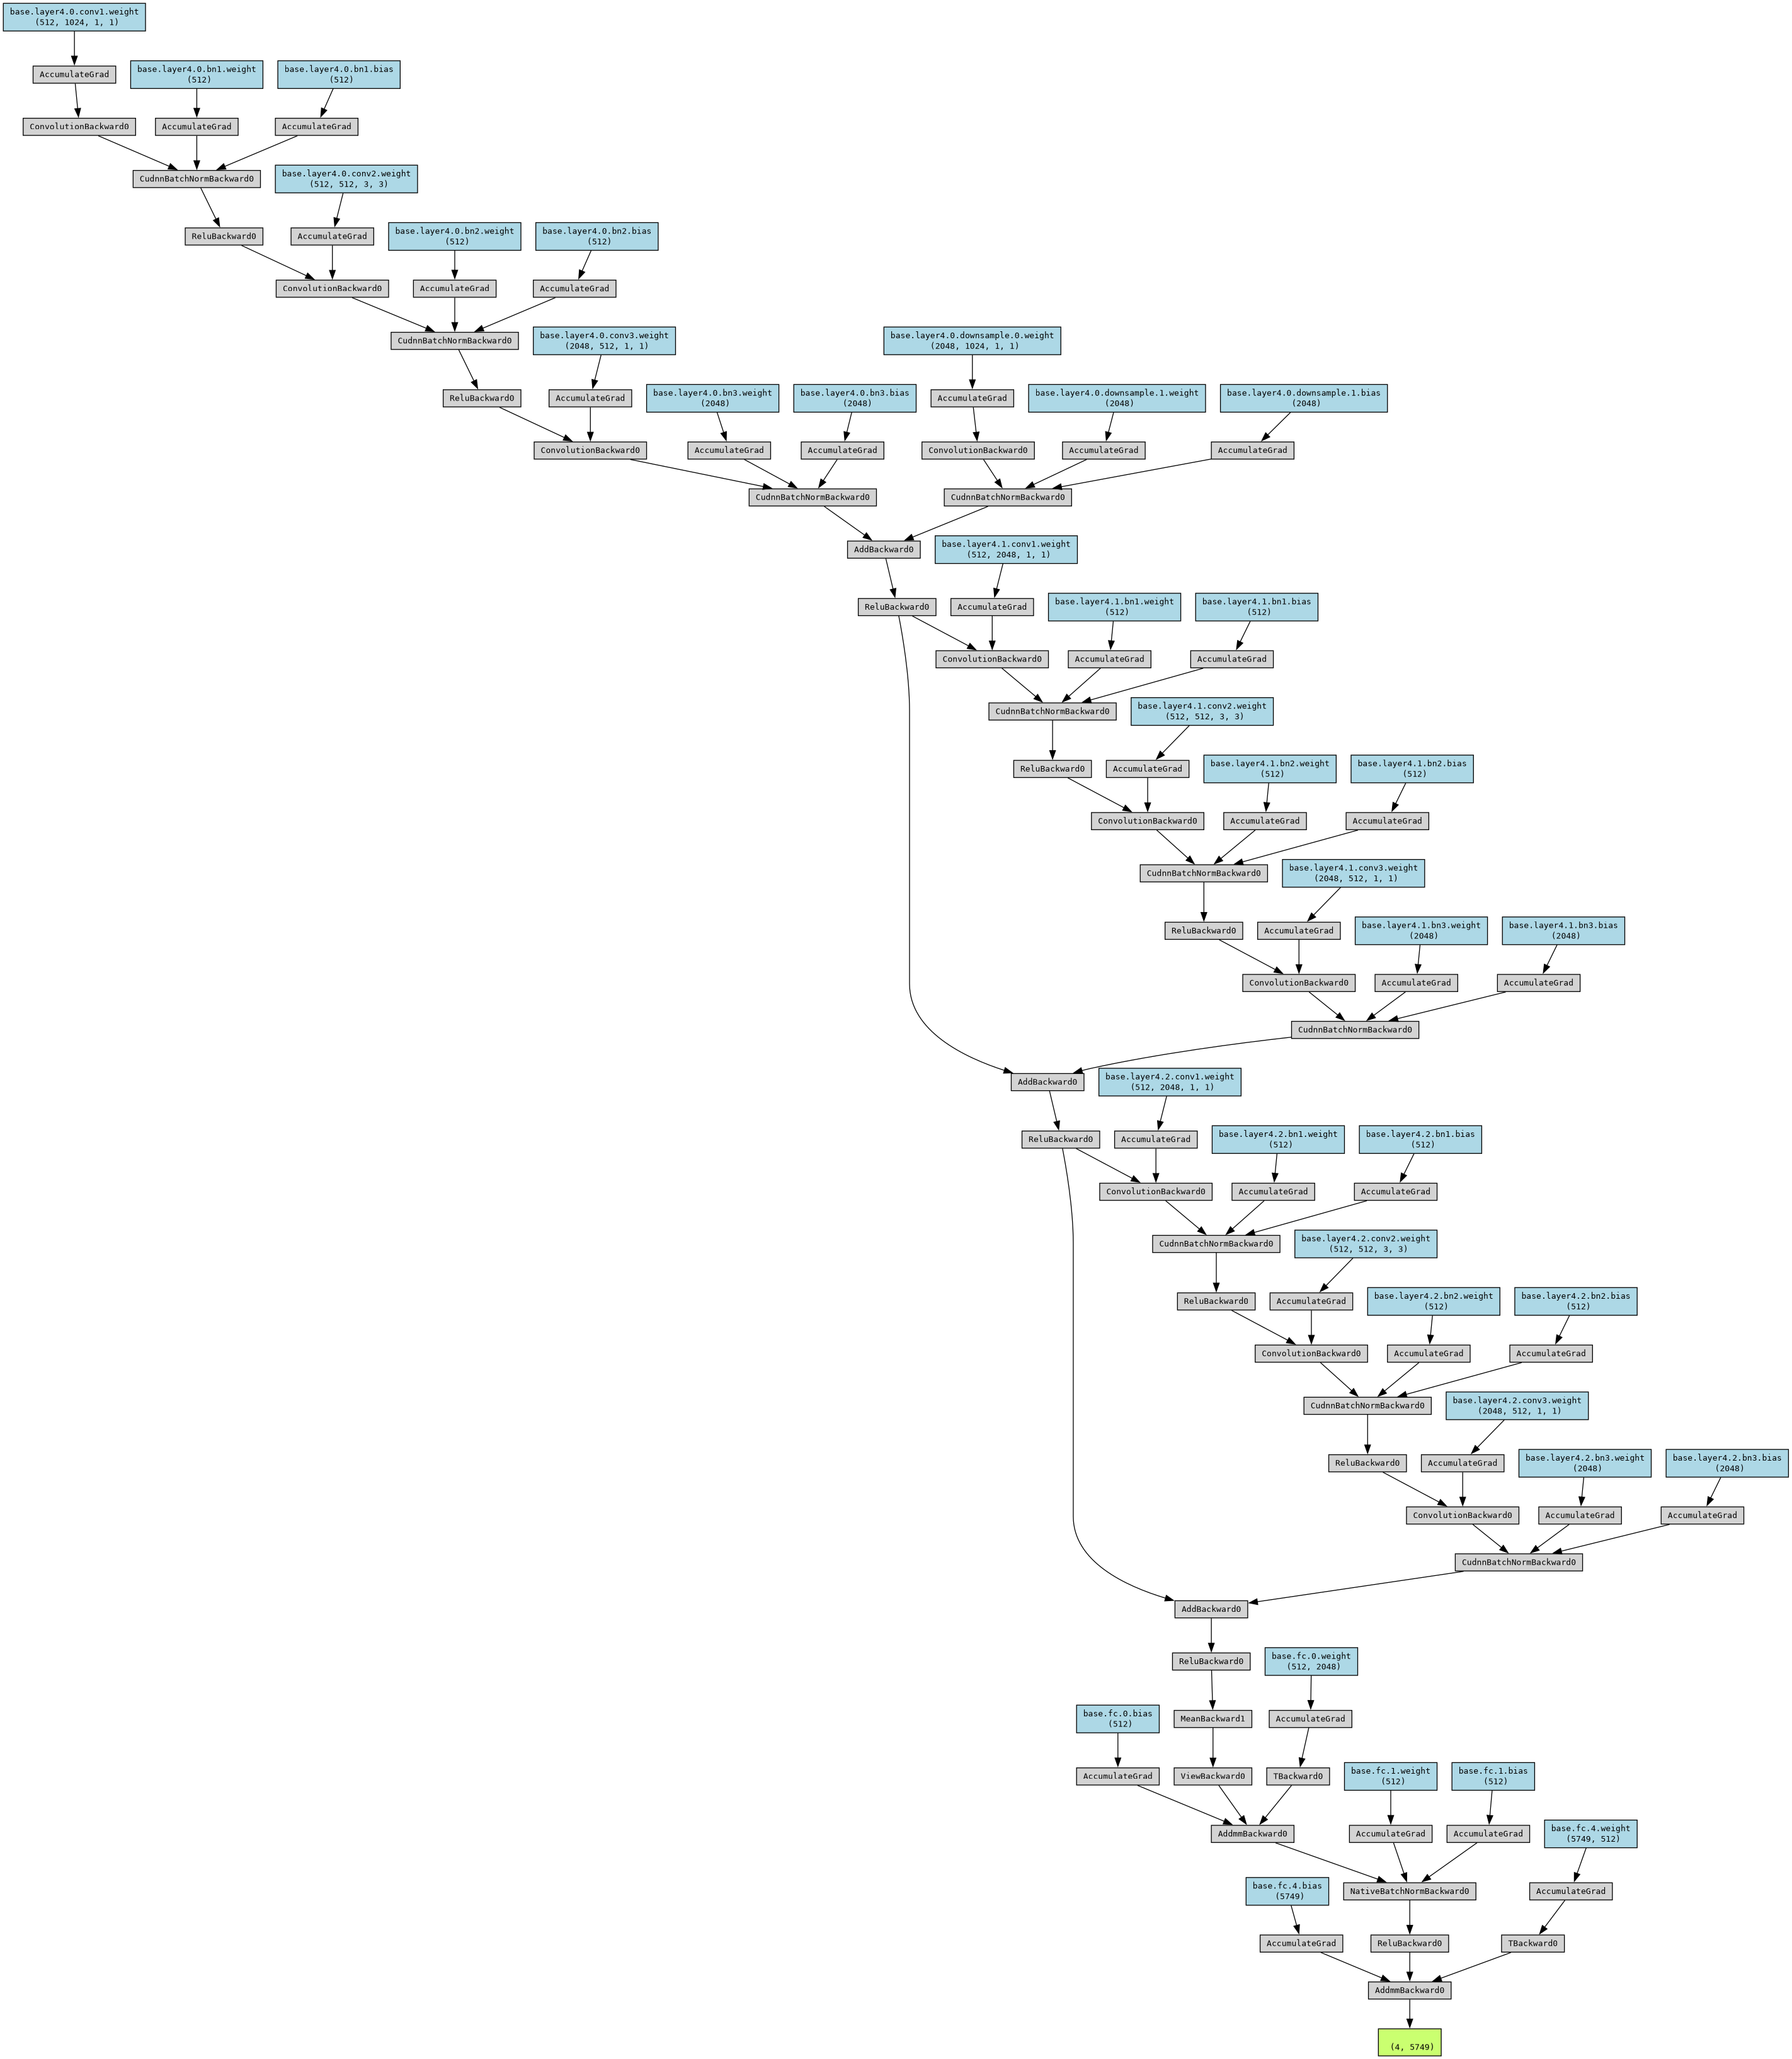


Training ArcFace
Epoch [1/50]
Train Loss: 8.3204, Train Acc: 3.77%
Val Loss: 7.6097, Val Acc: 4.19%
Epoch [2/50]
Train Loss: 7.7613, Train Acc: 4.97%
Val Loss: 7.4479, Val Acc: 6.42%
Epoch [3/50]
Train Loss: 7.5206, Train Acc: 5.96%
Val Loss: 7.2020, Val Acc: 6.99%
Epoch [4/50]
Train Loss: 7.2429, Train Acc: 7.17%
Val Loss: 6.8690, Val Acc: 8.22%
Epoch [5/50]
Train Loss: 6.9331, Train Acc: 8.58%
Val Loss: 6.6583, Val Acc: 10.07%
Epoch [6/50]
Train Loss: 6.6702, Train Acc: 9.84%
Val Loss: 6.6006, Val Acc: 10.95%
Epoch [7/50]
Train Loss: 6.3693, Train Acc: 10.66%
Val Loss: 6.3430, Val Acc: 13.14%
Epoch [8/50]
Train Loss: 6.0080, Train Acc: 12.59%
Val Loss: 6.0930, Val Acc: 14.22%
Epoch [9/50]
Train Loss: 5.6208, Train Acc: 14.19%
Val Loss: 5.8958, Val Acc: 15.60%
Epoch [10/50]
Train Loss: 5.2185, Train Acc: 15.89%
Val Loss: 5.9639, Val Acc: 16.91%
Epoch [11/50]
Train Loss: 4.8050, Train Acc: 18.04%
Val Loss: 5.9014, Val Acc: 18.22%
Epoch [12/50]
Train Loss: 4.3863, Train Acc: 20.16%
Val

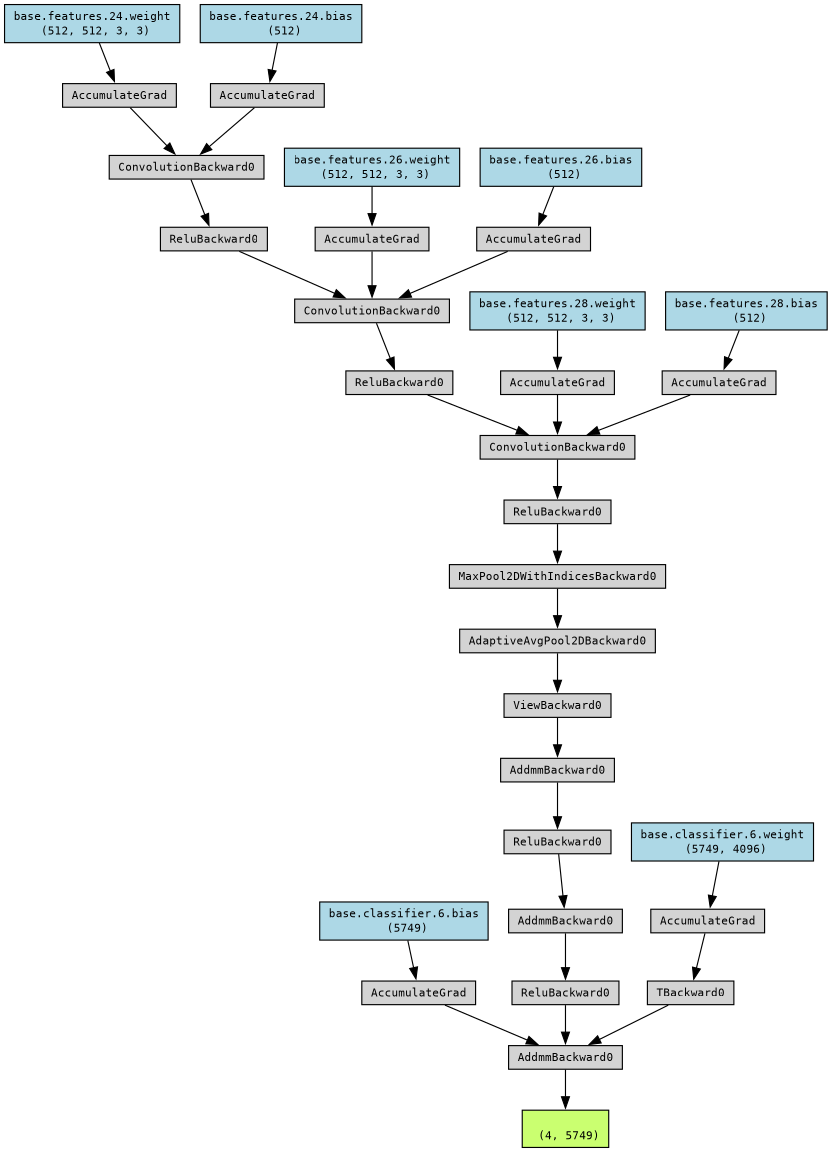


Training VGGFace
Epoch [1/50]
Train Loss: 8.0963, Train Acc: 3.78%
Val Loss: 7.5981, Val Acc: 4.07%
Epoch [2/50]
Train Loss: 7.7297, Train Acc: 4.35%
Val Loss: 7.3523, Val Acc: 5.15%
Epoch [3/50]
Train Loss: 7.5836, Train Acc: 5.15%
Val Loss: 7.3197, Val Acc: 5.42%
Epoch [4/50]
Train Loss: 7.4465, Train Acc: 5.37%
Val Loss: 7.2718, Val Acc: 6.34%
Epoch [5/50]
Train Loss: 7.3449, Train Acc: 6.08%
Val Loss: 7.2392, Val Acc: 6.34%
Epoch [6/50]
Train Loss: 7.2497, Train Acc: 6.41%
Val Loss: 7.1953, Val Acc: 6.96%
Epoch [7/50]
Train Loss: 7.1864, Train Acc: 7.32%
Val Loss: 7.0894, Val Acc: 8.99%
Epoch [8/50]
Train Loss: 7.0851, Train Acc: 8.09%
Val Loss: 7.0528, Val Acc: 8.26%
Epoch [9/50]
Train Loss: 7.0050, Train Acc: 8.21%
Val Loss: 6.9993, Val Acc: 9.07%
Epoch [10/50]
Train Loss: 6.9018, Train Acc: 8.89%
Val Loss: 6.8564, Val Acc: 9.45%
Epoch [11/50]
Train Loss: 6.8104, Train Acc: 9.29%
Val Loss: 6.8333, Val Acc: 10.42%
Epoch [12/50]
Train Loss: 6.6995, Train Acc: 9.86%
Val Loss: 6.837

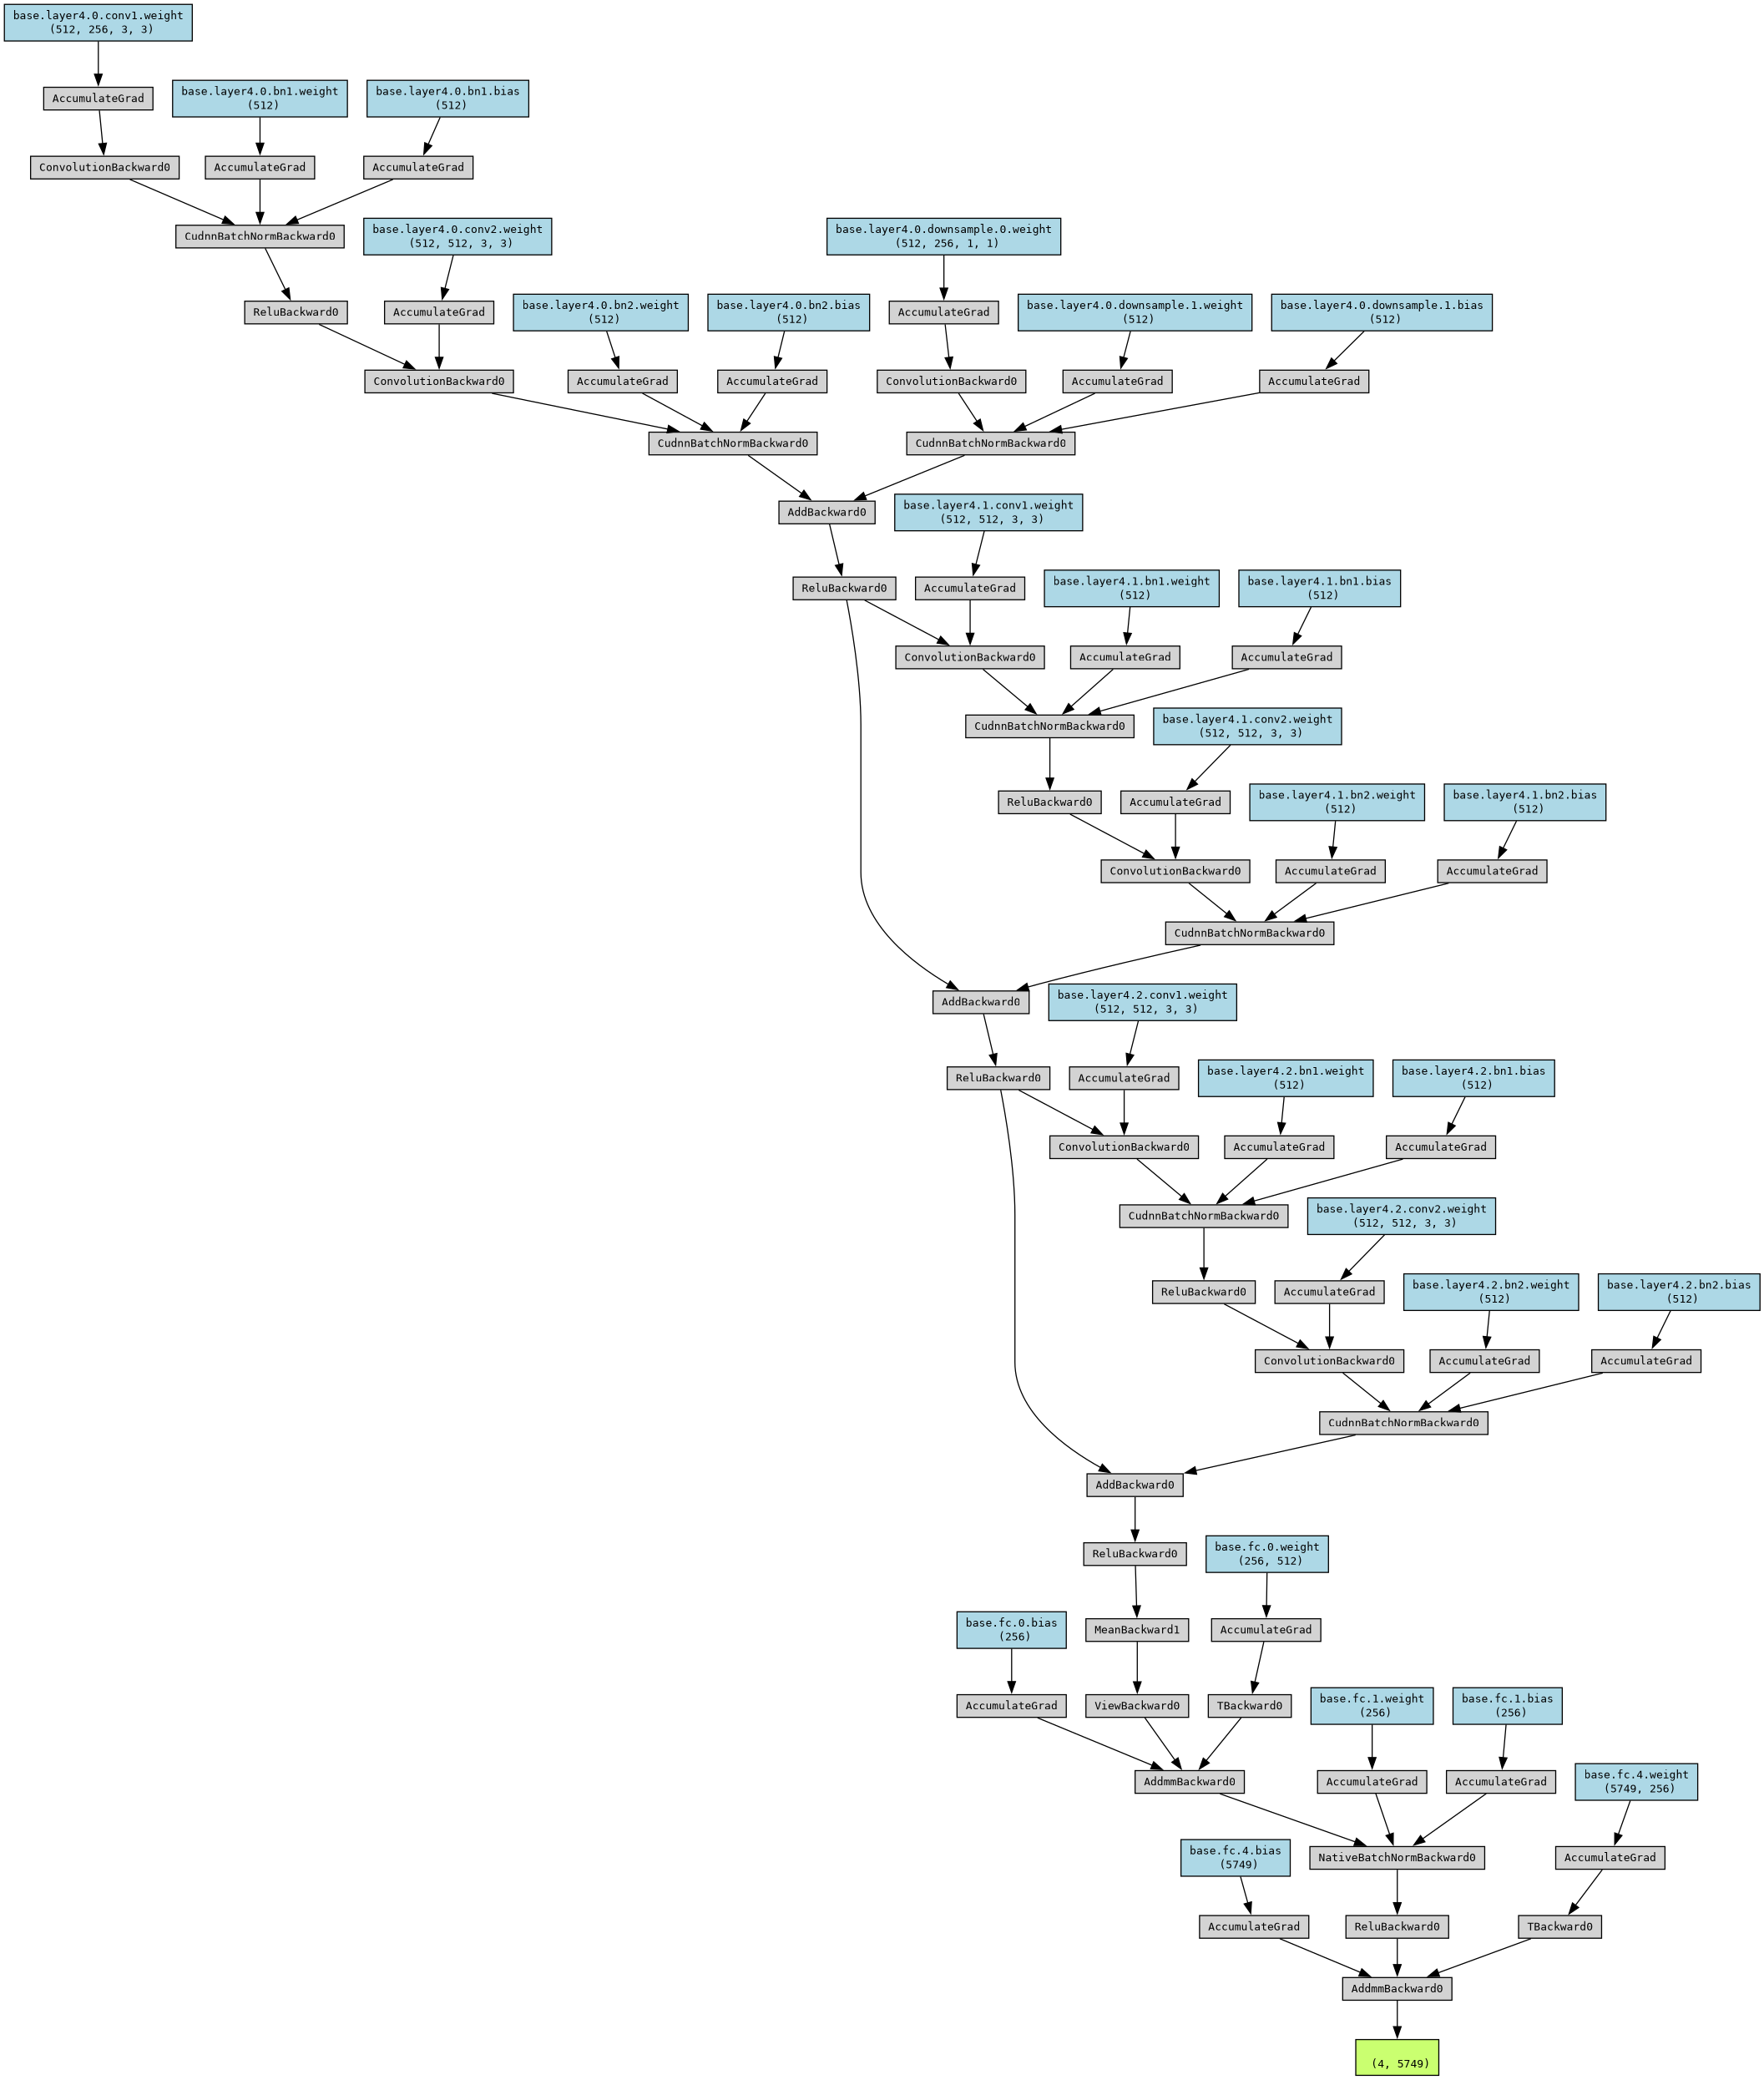


Training Dlib
Epoch [1/50]
Train Loss: 8.0992, Train Acc: 5.24%
Val Loss: 7.4294, Val Acc: 5.42%
Epoch [2/50]
Train Loss: 7.5842, Train Acc: 6.19%
Val Loss: 7.0720, Val Acc: 6.92%
Epoch [3/50]
Train Loss: 7.3101, Train Acc: 6.94%
Val Loss: 6.8233, Val Acc: 7.92%
Epoch [4/50]
Train Loss: 7.1079, Train Acc: 7.32%
Val Loss: 6.7945, Val Acc: 7.53%
Epoch [5/50]
Train Loss: 6.8442, Train Acc: 8.23%
Val Loss: 6.5790, Val Acc: 8.88%
Epoch [6/50]
Train Loss: 6.6126, Train Acc: 9.00%
Val Loss: 6.2119, Val Acc: 11.80%
Epoch [7/50]
Train Loss: 6.3485, Train Acc: 10.73%
Val Loss: 6.0628, Val Acc: 12.34%
Epoch [8/50]
Train Loss: 6.0996, Train Acc: 11.61%
Val Loss: 5.9078, Val Acc: 13.34%
Epoch [9/50]
Train Loss: 5.8549, Train Acc: 12.54%
Val Loss: 5.8834, Val Acc: 13.45%
Epoch [10/50]
Train Loss: 5.6039, Train Acc: 13.59%
Val Loss: 5.7046, Val Acc: 16.10%
Epoch [11/50]
Train Loss: 5.3725, Train Acc: 14.49%
Val Loss: 5.5617, Val Acc: 17.03%
Epoch [12/50]
Train Loss: 5.1823, Train Acc: 15.57%
Val Los

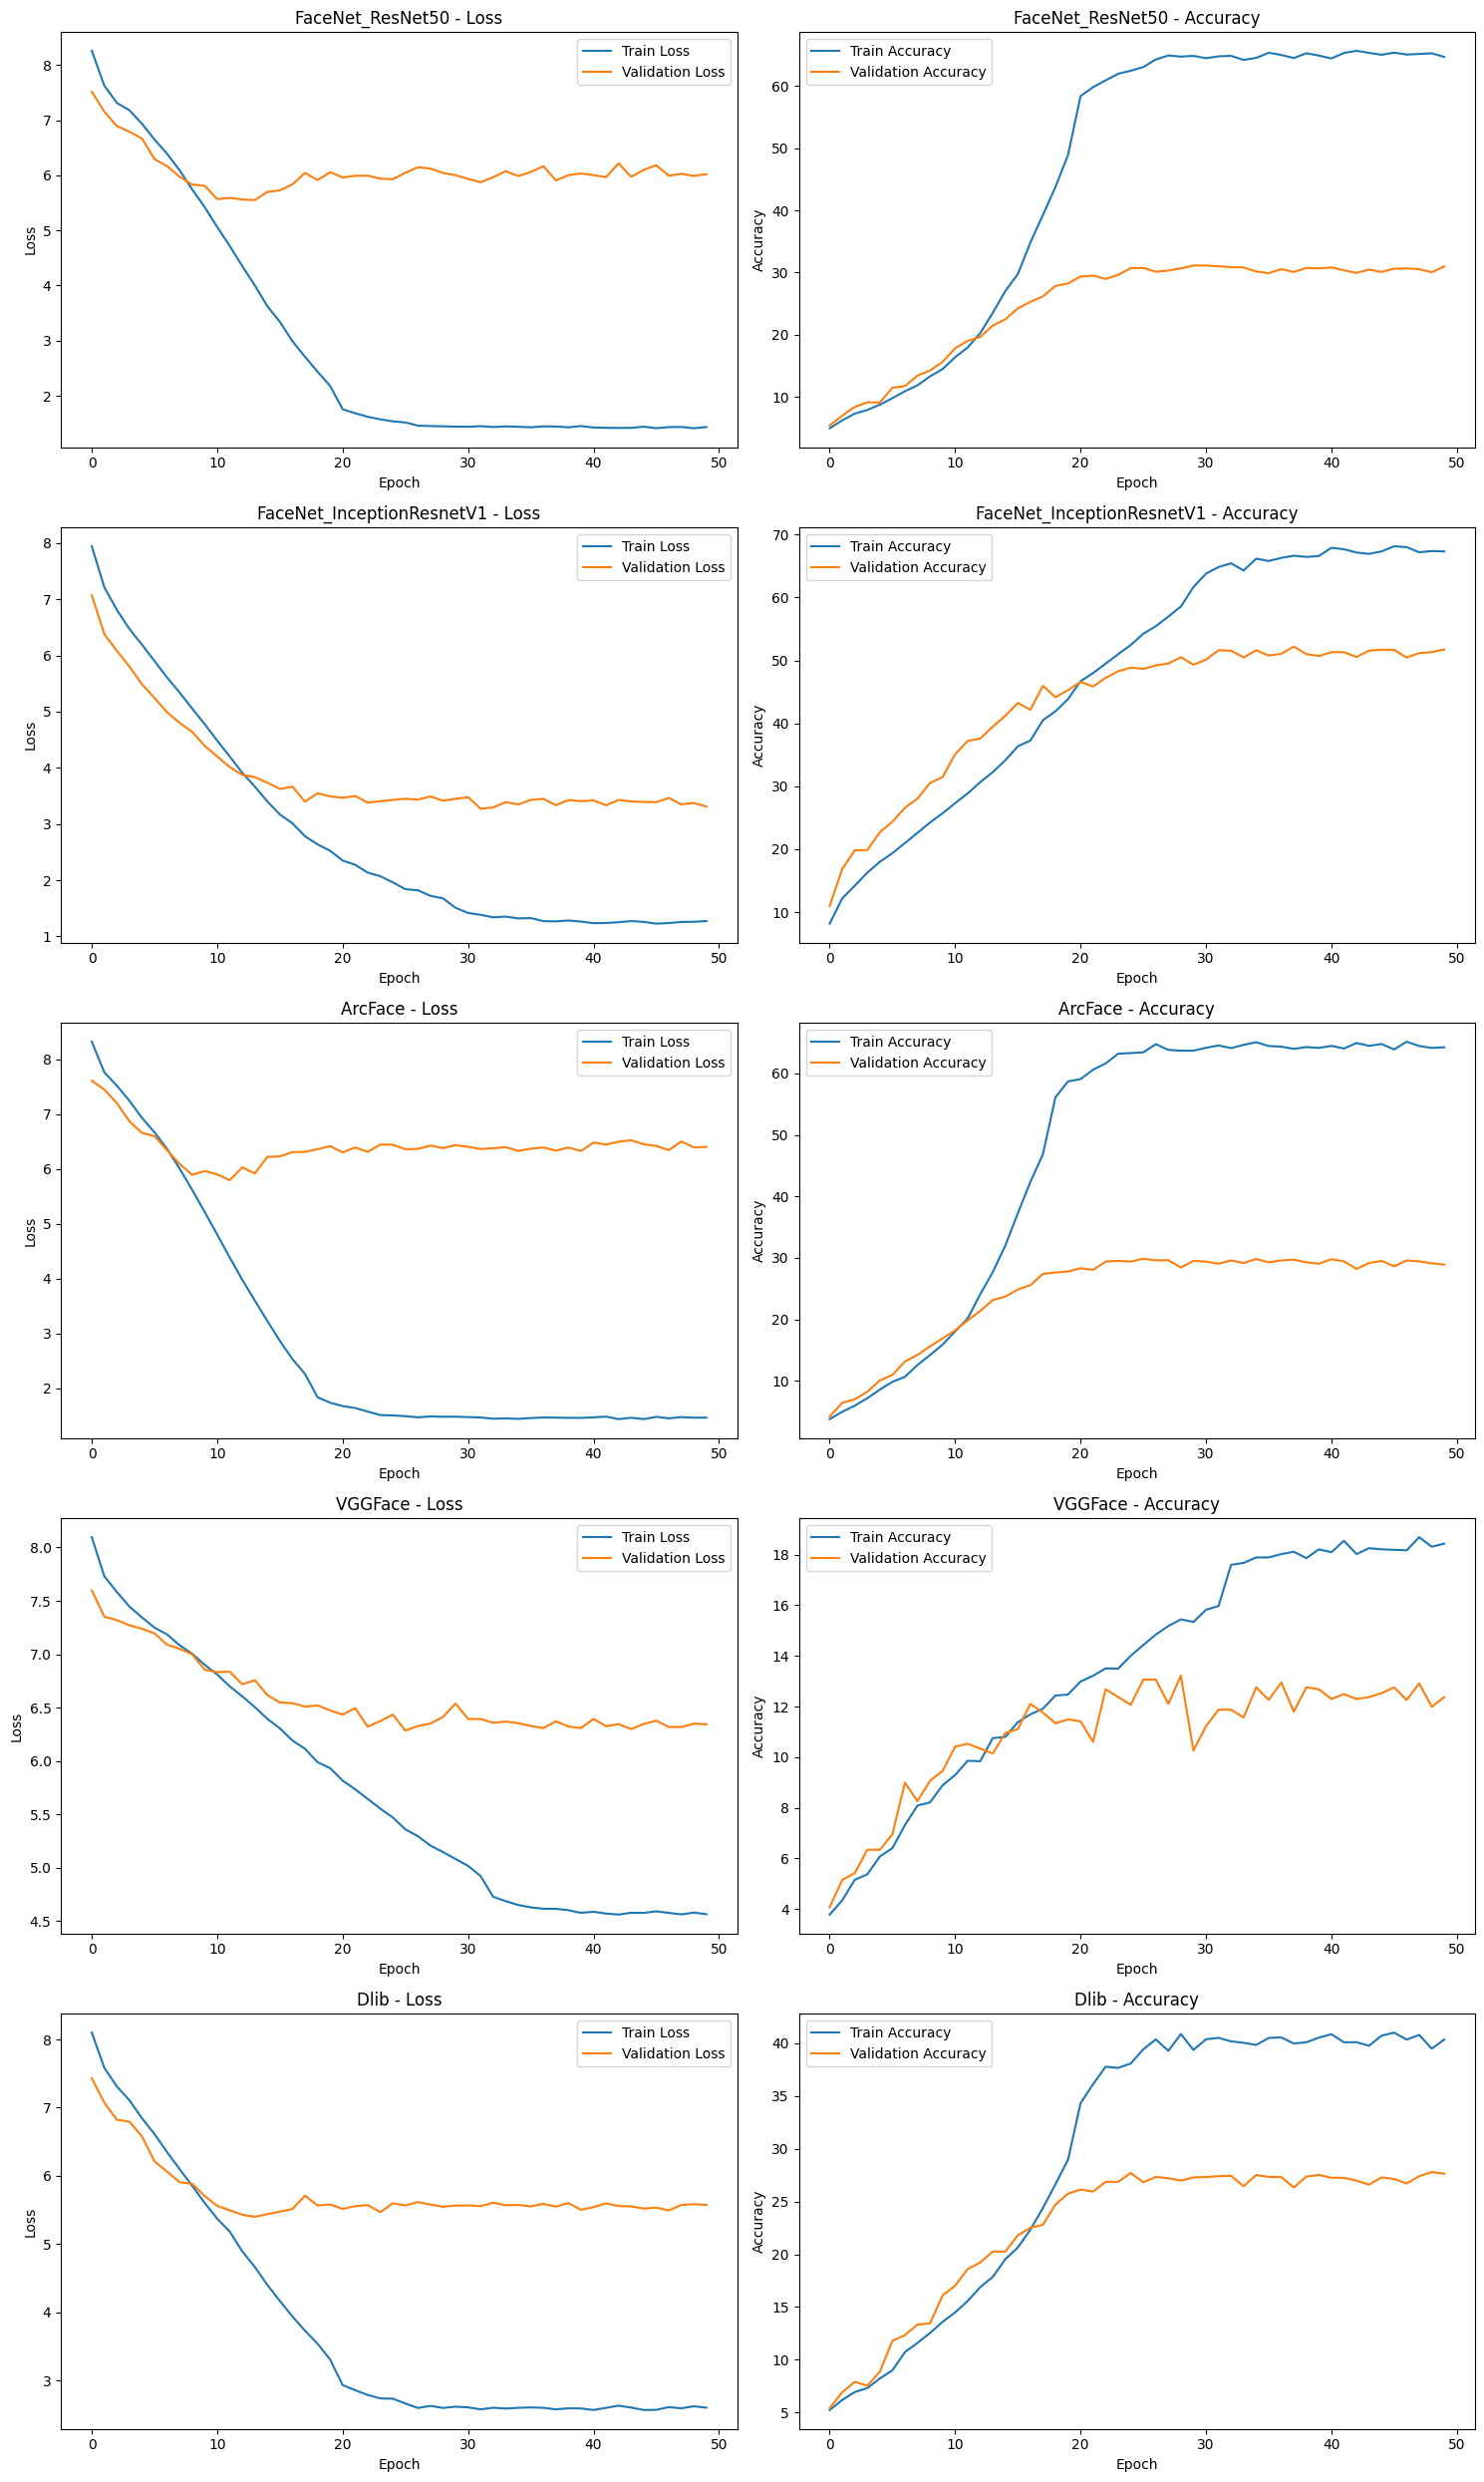

In [12]:
def main():
    print("Setting up Dlib models...")
    setup_dlib_models()
    
    print("Preparing datasets...")
    train_loader, val_loader, num_classes = prepare_data()
    
    models_config = {
        'FaceNet_ResNet50': {
            'model': FaceNetModel(num_classes),
            'criterion': nn.CrossEntropyLoss(),
            'lr': 0.001
        },
        'FaceNet_InceptionResnetV1': {
            'model': ImprovedFaceNet(num_classes),
            'criterion': nn.CrossEntropyLoss(),
            'lr': 0.001
        },
        'ArcFace': {
            'model': ArcFaceModel(num_classes),
            'criterion': nn.CrossEntropyLoss(),
            'lr': 0.001
        },
        'VGGFace': {
            'model': VGGFaceModel(num_classes),
            'criterion': nn.CrossEntropyLoss(),
            'lr': 0.001
        },
        'Dlib': {
            'model': DlibFaceModel(num_classes),
            'criterion': nn.CrossEntropyLoss(),
            'lr': 0.001
        }
    }
    
    results = {}
    
    for model_name, config in models_config.items():
        print(f"\nPreparing {model_name}")
        model = config['model'].to(device)
        criterion = config['criterion']
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
        
        # Visualize model architecture
        print(f"Visualizing {model_name} architecture")
        visualize_model_architecture(model)
        
        
        print(f"\nTraining {model_name}")
        history, best_acc = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=50,
            model_name=model_name
        )
        
        results[model_name] = {
            'history': history,
            'best_acc': best_acc
        }
            
    
    print("\nModel Comparison Results:")
    for model_name, result in results.items():
        print(f"{model_name}: Best Validation Accuracy = {result['best_acc']:.4f}")

    # Plot training progress for all models
    plot_training_progress(results)

if __name__ == "__main__":
    main()

# **Conclusion**

In this notebook, explored and compared the performance of five face recognition models: FaceNet with ResNet50, FaceNet with InceptionResnetV1, ArcFace, VGGFace, and Dlib. By analyzing the validation accuracy and training progress of each model, we were able to identify the most effective architecture for our dataset. These results provide a foundation for selecting models in real-world face recognition applications, where accuracy, complexity, and inference speed are all critical considerations.
